# Towards Doppler Imaging

The design of `blase` is well-suited to discovering semi-empirical templates for Doppler Imaging and---eventually---directly learning the surface feature map that gave rise to individual perturbations.  This latter capability is not yet implemented in `blase`, but it's not too far off to imagine how to make it work.  Here we show the precursor work of fitting a unform stellar disk with a fixed $v\sin{i}$ to a "Solar-like" benchmark Doppler Imaging target, [EK Dra](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=EK%20Dra).

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cuda'

## Pre-process the data
We will quickly pre-process the HPF spectrum with the [muler](https://muler.readthedocs.io/en/latest/) library

In [4]:
from muler.hpf import HPFSpectrum

In [5]:
raw_data = HPFSpectrum(file='../../../star-witness/data/HPF/goldilocks/UT21-1-020/Goldilocks_20210224T120315_v1.0_0049.spectra.fits', order=2)

In [6]:
data = raw_data.sky_subtract()\
                .trim_edges()\
                .remove_nans()\
                .deblaze()\
                .flatten(window_length=301,sigma=2)\
                .normalize(normalize_by='peak')

In [7]:
wl_lo = 8300-30.0
wl_hi = 8420+30.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

### Retrieve the Phoenix model

EK Dra has $T_{\mathrm{eff}}=5700\;K$ and $\log{g}\sim5.0$, according to sources obtained through NASA Exoplanet Archive (Bonomo et al. 2017, Stassun et al. 2017, Anderson et al. 2014, and references therein).  Let's start with a PHOENIX model possessing these properties.

In [8]:
from gollum.phoenix import PHOENIXGrid

In [9]:
grid = PHOENIXGrid(teff_range=(4700, 5800), logg_range=(2, 5.5), metallicity_range=(-1, 0),
                   wl_lo=wl_lo, wl_hi=wl_hi)

Processing Teff=5800K|log(g)=5.50|Z=+0.0: 100%|█████████████| 288/288 [00:02<00:00, 105.19it/s]


Let's write down the Barycentric Earth Radial Velocity to correct for RV shifts.

In [10]:
BERV = data.estimate_barycorr().to(u.km/u.s).value
BERV

1.4262703938479389

Find the best fit template with the [interactive dashboard](https://gollum-astro.readthedocs.io/en/latest/tutorials/Phoenix_dashboard_demo.html).

The javascript dashboard cannot be shown easily only due to a Python backend server connection.  Try it for yourself by installing [gollum](https://gollum-astro.readthedocs.io/en/latest/install.html).

In [11]:
#grid.show_dashboard(data=data)

From the interactive dashboard, we find:

| Property| HPF by-eye fit| Gaia DR3 |
| -- | -- | -- |
|$T_{\mathrm{eff}}$| 5400 K| 5423 K|
|$\log{g}$| 4.5| 4.3 |
|Metallicty| -0.5| -0.85 |
|$v\sin{i}$| 14.9 km/s|  24.0 km/s|
|$v_z$|-22.3 km/s| $\cdots$ |
|RV|-20.87 km/s| -21.1 km/s|

Pretty consistent!

In [12]:
system_RV = -20.87 #km/s
observed_RV = -22.3 # system_RV - BERV (km/s)
vsini = 14.9 #km/s
resolving_power = 55_000

In [13]:
native_spectrum = PHOENIXSpectrum(teff=5400, logg=4.5, metallicity=-0.5, wl_lo=wl_lo, wl_hi=wl_hi)
native_spectrum = native_spectrum.divide_by_blackbody()
native_spectrum = native_spectrum.normalize()
continuum_fit = native_spectrum.fit_continuum(polyorder=5)
native_spectrum = native_spectrum.divide(continuum_fit, handle_meta="ff")
spectrum = native_spectrum.rotationally_broaden(vsini)
spectrum = spectrum.rv_shift(observed_RV)
spectrum = spectrum.instrumental_broaden(resolving_power=resolving_power)

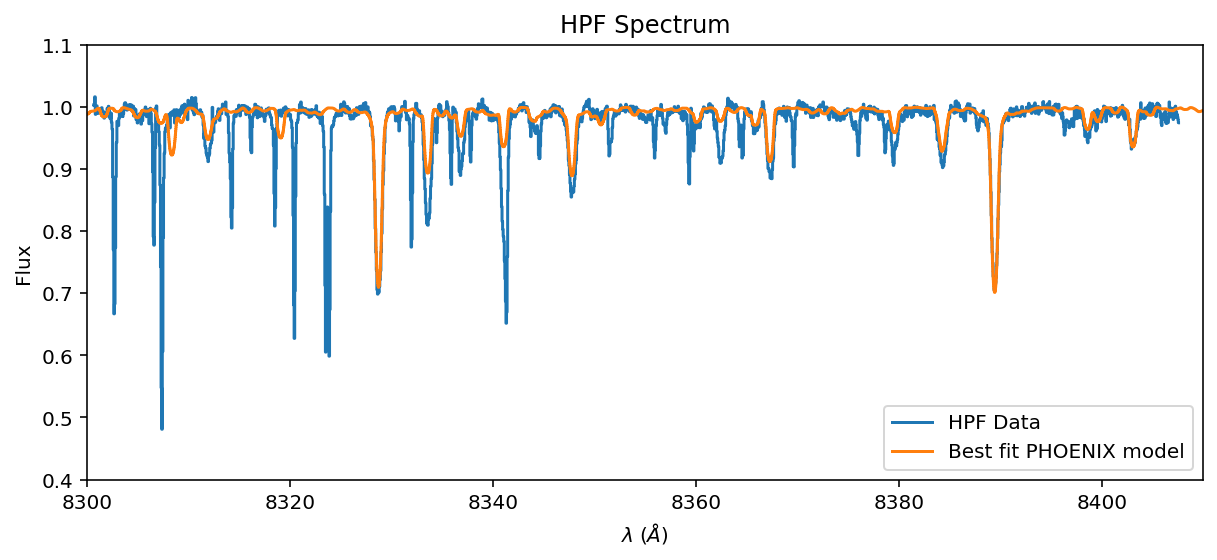

In [14]:
ax = data.plot(yhi=1.1, ylo=0.4, label='HPF Data')
spectrum.plot(ax=ax, label='Best fit PHOENIX model')
ax.set_xlim(8300, 8410); ax.legend();

You can see that that the best fit still falls short of perfection, and there are lots of telluric lines to address...

### Retrieve the TelFit Telluric model

Let's pick a precomputed TelFit model with comparable temperature and humidity as the data.  You can improve on your initial guess by tuning a TelFit model from scratch.  We choose to skip this laborious step here, but encourage practitioners to try it on their own.

In [15]:
data.meta['header']['ENVTEM'], data.meta['header']['ENVHUM'] # Fahrenheit and Relative Humidity

(53.67, 11.206)

The closest precomputed TelFit point has 286 Kelvin and 10% humidity... Dry!

In [16]:
web_link = 'https://utexas.box.com/shared/static/g4ox0s1f6pjkwnzvpiue85vc3pk3v0g0.txt'

In [17]:
telluric_spectrum_full = TelFitSpectrum(path=web_link).air_to_vacuum()
mask = ((telluric_spectrum_full.wavelength.value > wl_lo) &
        (telluric_spectrum_full.wavelength.value < wl_hi) )
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = np.abs(telluric_spectrum.flux.value)
telluric_lnflux = np.log(telluric_flux) # "natural log" or log base `e`
telluric_lnflux[telluric_lnflux < -15] = -15

## Initial guess

In [18]:
initial_guess = spectrum.resample(data)

initial_telluric = telluric_spectrum.instrumental_broaden(resolving_power)\
                                         .resample(data)

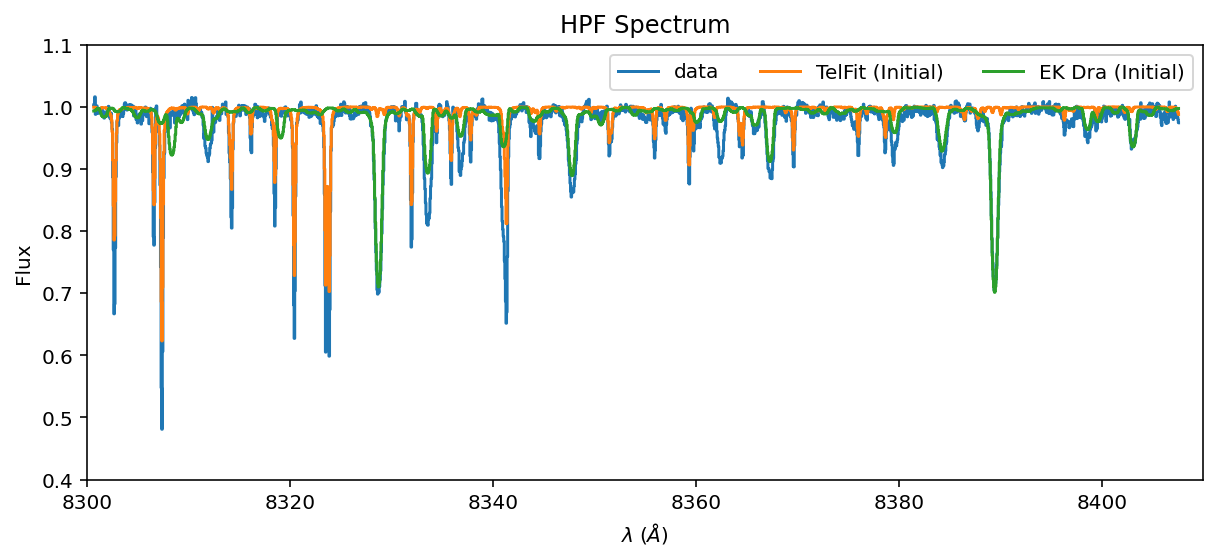

In [19]:
ax = data.plot(label='data', yhi=1.1, ylo=0.4)
initial_telluric.plot(ax=ax, label='TelFit (Initial)')
initial_guess.plot(ax=ax, label='EK Dra (Initial)')
ax.set_xlim(8300, 8410); ax.legend(ncol=3);

Ok, the lines are in the right place, but the amplitudes are inexact.  Let's tune them with `blase`!

### Clone the stellar and telluric model

In [20]:
stellar_emulator = SparseLogEmulator(native_spectrum.wavelength.value, 
                                     np.log(native_spectrum.flux.value), prominence=0.01, device=device)
stellar_emulator.to(device)

/home/gully/GitHub/blase/src/blase/emulator.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


Initializing a sparse model with 175 spectral lines


SparseLogEmulator()

In [21]:
telluric_emulator = SparseLogEmulator(telluric_spectrum.wavelength.value, 
                                      np.log(telluric_spectrum.flux.value), 
                                      prominence=0.01, device=device)
telluric_emulator.to(device)

Initializing a sparse model with 80 spectral lines


SparseLogEmulator()

### Fine-tune the clone

In [22]:
stellar_emulator.optimize(epochs=1000, LR=0.01)

Training Loss: 0.00001552: 100%|██████████████████████████| 1000/1000 [00:04<00:00, 220.40it/s]


In [23]:
telluric_emulator.optimize(epochs=1000, LR=0.01)

Training Loss: 0.00000223: 100%|██████████████████████████| 1000/1000 [00:04<00:00, 223.99it/s]


### Step 3: Extrinsic model

In [24]:
extrinsic_layer = ExtrinsicModel(wavelength_grid, device=device)
vsini = torch.tensor(vsini)
extrinsic_layer.ln_vsini.data = torch.log(vsini)
extrinsic_layer.to(device)

ExtrinsicModel()

(Remap the stellar and telluric emulator to a standardized wavelength grid).

In [25]:
stellar_emulator = SparseLogEmulator(wavelength_grid, 
                                     init_state_dict=stellar_emulator.state_dict(), device=device)
stellar_emulator.radial_velocity.data = torch.tensor(observed_RV)
stellar_emulator.to(device)
telluric_emulator = SparseLogEmulator(wavelength_grid, 
                                     init_state_dict=telluric_emulator.state_dict(), device=device)
telluric_emulator.to(device)

Initializing a sparse model with 175 spectral lines
Initializing a sparse model with 80 spectral lines


SparseLogEmulator()

#### Forward model

In [26]:
stellar_flux = stellar_emulator.forward()
broadened_flux = extrinsic_layer(stellar_flux)
telluric_attenuation = telluric_emulator.forward()

#### Joint telluric and stellar model

In [27]:
flux_at_telescope = broadened_flux * telluric_attenuation

#### Instrumental model

In [28]:
instrumental_model = InstrumentalModel(data.bin_edges.value, wavelength_grid, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [29]:
instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.064))

In [30]:
detector_flux = instrumental_model.forward(flux_at_telescope)

(8320.0, 8340.0)

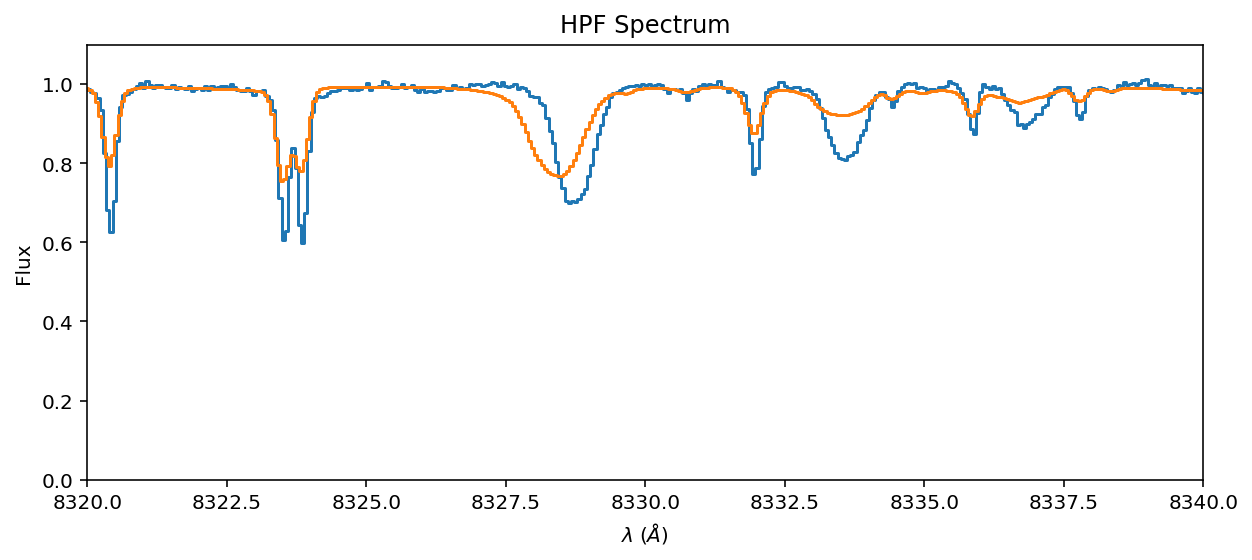

In [31]:
ax = data.plot(yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());
ax.set_xlim(8320, 8340)

## Transfer learn a semi-empirical model

In [32]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [33]:
data_target = torch.tensor(
    data.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    data.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [34]:
loss_fn = nn.MSELoss(reduction="mean")

### Fix certain parameters, allow others to vary
As we have seen before, you can fix parameters by "turning off their gradients".  We will start by turning off *ALL* gradients.  Then turn on some.

In [35]:
for model in [stellar_emulator, telluric_emulator, extrinsic_layer, instrumental_model]:
    for key in stellar_emulator.state_dict().keys():
        stellar_emulator.__getattr__(key).requires_grad = False

In [36]:
stellar_emulator.amplitudes.requires_grad = True
stellar_emulator.lam_centers.requires_grad = True
stellar_emulator.radial_velocity.requires_grad = True
telluric_emulator.amplitudes.requires_grad = True
instrumental_model.ln_sigma_angs.requires_grad = True

In [37]:
optimizer = optim.Adam(
    list(filter(lambda p: p.requires_grad, stellar_emulator.parameters()))
    + list(filter(lambda p: p.requires_grad, telluric_emulator.parameters()))
    + list(filter(lambda p: p.requires_grad, extrinsic_layer.parameters()))
    + list(filter(lambda p: p.requires_grad, instrumental_model.parameters())),
    0.01,
    amsgrad=True,
)         

In [38]:
n_epochs = 2000
losses = []

## Regularization is fundamental

The blase model as it stands is **too flexible**.  It must have regularization to balance its propensity to overfit.

First, we need to assign uncertainty to the data in order to weigh the prior against new data:

In [39]:
# We need uncertainty to be able to compute the posterior
# Assert fixed per-pixel uncertainty for now
per_pixel_uncertainty = torch.tensor(0.005, device=device, dtype=torch.float64)

Then we need the prior.  For now, let's just apply priors on the amplitudes (almost everything else is fixed).  We need to set the regularization hyperparameter tuning.

In [40]:
stellar_amp_regularization = 0.05
telluric_amp_regularization = 0.05
stellar_lam_regularization = 0.5

In [41]:
import copy

In [42]:
with torch.no_grad():
    stellar_init_amps = copy.deepcopy(torch.exp(stellar_emulator.amplitudes))
    telluric_init_amps = copy.deepcopy(torch.exp(telluric_emulator.amplitudes))
    stellar_init_lams = copy.deepcopy(stellar_emulator.lam_centers)

# Define the prior on the amplitude
def ln_prior(stellar_amps, telluric_amps, lam_centers):
    """
    Prior for the amplitude vector
    """
    amp_diff1 = stellar_init_amps - torch.exp(stellar_amps)
    ln_prior1 = 0.5 * torch.sum((amp_diff1 ** 2) / (stellar_amp_regularization ** 2))
    
    amp_diff2 = telluric_init_amps - torch.exp(telluric_amps)
    ln_prior2 = 0.5 * torch.sum((amp_diff2 ** 2) / (telluric_amp_regularization ** 2))
    
    lam_diff1 = stellar_init_lams - lam_centers
    ln_prior3 = 0.5 * torch.sum((lam_diff1 ** 2) / (stellar_lam_regularization ** 2))

    return ln_prior1 + ln_prior2 + ln_prior3

In [43]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    stellar_emulator.train()
    telluric_emulator.train()
    extrinsic_layer.train()
    instrumental_model.train()
    
    stellar_flux = stellar_emulator.forward()
    broadened_flux = extrinsic_layer(stellar_flux)
    telluric_attenuation = telluric_emulator.forward()
    flux_at_telescope = broadened_flux * telluric_attenuation
    detector_flux = instrumental_model.forward(flux_at_telescope)
    
    loss = loss_fn(detector_flux / per_pixel_uncertainty, data_target / per_pixel_uncertainty)
    loss += ln_prior(stellar_emulator.amplitudes, 
                     telluric_emulator.amplitudes,
                     stellar_emulator.lam_centers)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 4.61689038: 100%|███████████████████████████| 2000/2000 [02:39<00:00, 12.54it/s]


### Spot check the transfer-learned joint model

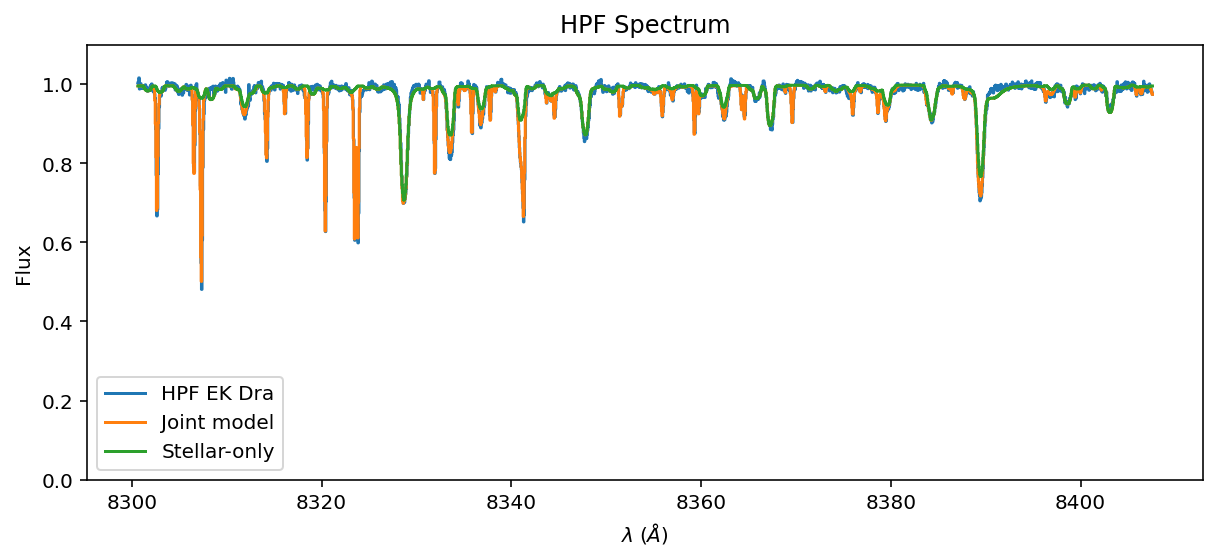

In [44]:
ax = data.plot(yhi=1.1, label='HPF EK Dra')
ax.step(data.wavelength, detector_flux.detach().cpu().numpy(), label='Joint model');
ax.step(data.wavelength, instrumental_model.forward(broadened_flux).detach().cpu().numpy(),
       label='Stellar-only');
ax.legend();

(8320.0, 8340.0)

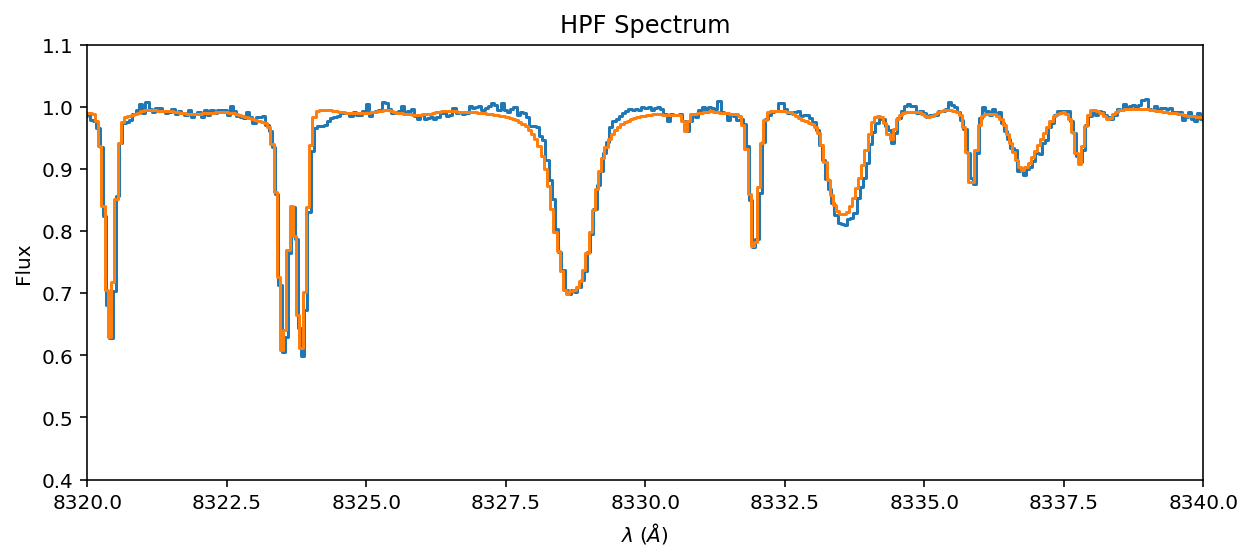

In [45]:
ax = data.plot(yhi=1.1, ylo=0.4)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());
ax.set_xlim(8320, 8340)

### Inspect the individual stellar and telluric components

In [46]:
with torch.no_grad():
    stellar_emulator.radial_velocity.data *=0
    stellar_post = stellar_emulator.forward().cpu().numpy()
    telluric_post = telluric_emulator.forward().cpu().numpy()

(8320.0, 8340.0)

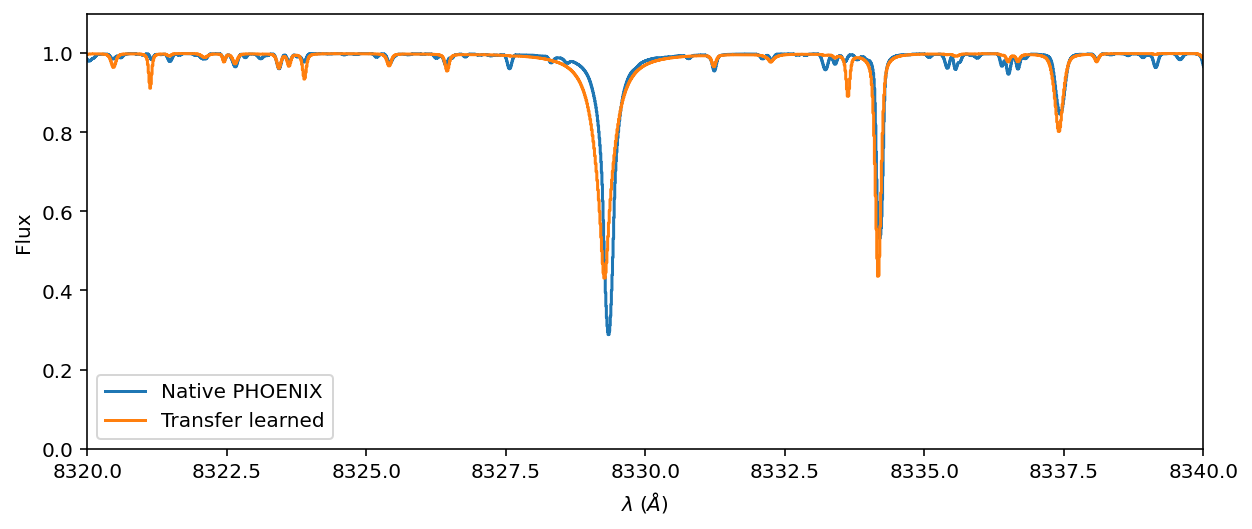

In [49]:
ax = native_spectrum.plot(ylo=0, yhi=1.1, label='Native PHOENIX')
ax.step(wavelength_grid, stellar_post, label='Transfer learned');
ax.legend()
ax.set_xlim(8320, 8340)

You can see that the telluric and stellar models compensated for imperfections in the line wings by overbloating the amplitudes of bystander lines.  This unlikely tradeoff makes sense once the line is convolved with an instrument kernel.

(8320.0, 8340.0)

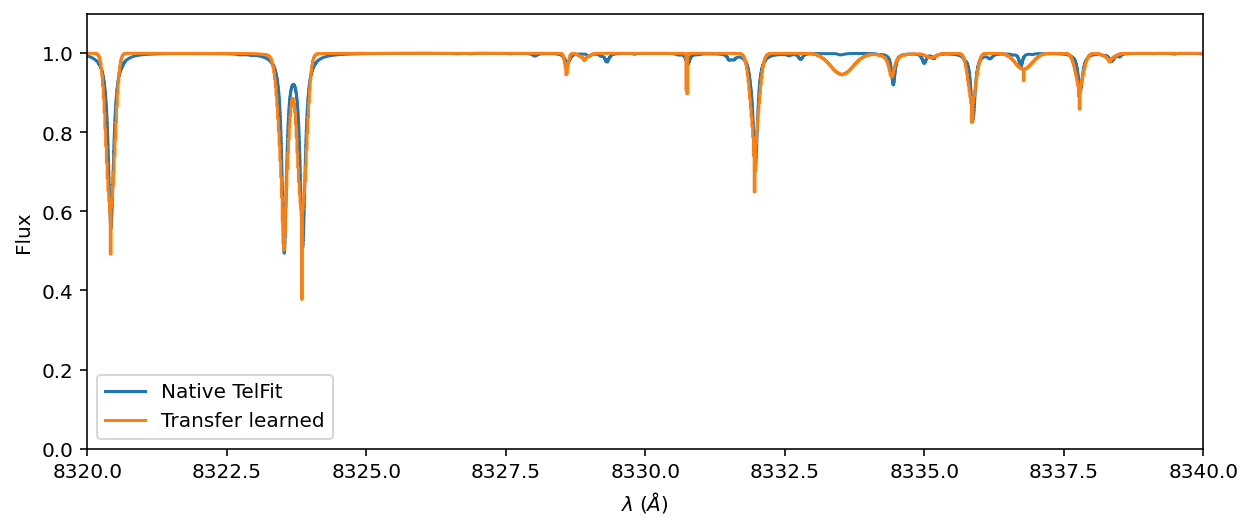

In [50]:
ax = telluric_spectrum.plot(ylo=0, yhi=1.1, label='Native TelFit')
ax.step(wavelength_grid, telluric_post, label='Transfer learned');
ax.legend()
ax.set_xlim(8320, 8340)

Not bad! We have learned the super-resolution templates.